In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
from PIL import Image
import os
import json
import matplotlib.pyplot as plt
import numpy as np
import kagglehub
from tqdm import tqdm
import random

In [2]:
# GPU 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [3]:
# 하이퍼파라미터 설정
BATCH_SIZE = 32
IMG_SIZE = 288
NUM_CLASSES = 101

In [4]:
class Food101Dataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(self.classes)}
        
        # 모든 이미지 경로와 라벨 수집
        self.samples = []
        for class_name in self.classes:
            class_dir = os.path.join(root_dir, class_name)
            if os.path.isdir(class_dir):
                for img_name in os.listdir(class_dir):
                    if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                        img_path = os.path.join(class_dir, img_name)
                        self.samples.append((img_path, self.class_to_idx[class_name]))
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        
        try:
            image = Image.open(img_path).convert('RGB')
            original_image = np.array(image)  # numpy array로 변환
            if self.transform:
                image = self.transform(image)
            return image, label, original_image, img_path
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            return self.__getitem__(0)

class EfficientNetB2Classifier(nn.Module):
    def __init__(self, num_classes=101, pretrained=True):
        super(EfficientNetB2Classifier, self).__init__()
        
        # EfficientNet-B2 백본 로드
        self.backbone = models.efficientnet_b2(pretrained=pretrained)
        
        # 분류기 교체
        num_features = self.backbone.classifier[1].in_features
        self.backbone.classifier = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, num_classes)
        )
    
    def forward(self, x):
        return self.backbone(x)

In [5]:
def load_model_and_classes():
    """저장된 모델과 클래스 정보 로드"""
    
    # 클래스 정보 로드
    with open('class_names.json', 'r') as f:
        class_names = json.load(f)
    
    # 모델 초기화 및 가중치 로드
    model = EfficientNetB2Classifier(num_classes=NUM_CLASSES, pretrained=False)
    checkpoint = torch.load('best_food101_efficientnet_b2.pth', map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.to(device)
    model.eval()
    
    print(f"Model loaded successfully!")
    print(f"Best validation accuracy: {checkpoint['val_acc']:.2f}%")
    
    return model, class_names

def custom_collate_fn(batch):
    """커스텀 collate function - 다양한 크기의 원본 이미지 처리"""
    tensors, labels, original_images, img_paths = zip(*batch)
    
    # 텐서와 라벨은 기본 방식으로 스택
    tensors = torch.stack(tensors, dim=0)
    labels = torch.tensor(labels)
    
    # 원본 이미지와 경로는 리스트로 유지
    return tensors, labels, list(original_images), list(img_paths)

def get_test_data():
    """테스트 데이터 로드"""
    
    # Kaggle 데이터셋 경로
    print("Loading dataset...")
    path = kagglehub.dataset_download("kmader/food41")
    data_dir = os.path.join(path, "images")
    
    # 데이터 전처리 (검증용)
    test_transforms = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # 전체 데이터셋 로드
    full_dataset = Food101Dataset(data_dir, transform=test_transforms)
    
    # 데이터 분할 (동일한 비율로)
    total_size = len(full_dataset)
    train_size = int(0.7 * total_size)
    val_size = int(0.15 * total_size)
    test_size = total_size - train_size - val_size
    
    # 시드 고정하여 동일한 분할
    torch.manual_seed(42)
    train_dataset, val_dataset, test_dataset = random_split(
        full_dataset, [train_size, val_size, test_size]
    )
    
    # 테스트 데이터 로더 (custom collate function 사용)
    test_loader = DataLoader(
        test_dataset, 
        batch_size=BATCH_SIZE, 
        shuffle=True, 
        num_workers=0,  # num_workers=0으로 변경
        collate_fn=custom_collate_fn
    )
    
    return test_loader

In [6]:
def predict_and_visualize(model, test_loader, class_names, num_samples=16):
    """예측 결과 시각화"""
    
    model.eval()
    predictions = []
    
    with torch.no_grad():
        for data, target, original_images, img_paths in test_loader:
            data = data.to(device)
            
            # 예측
            with torch.cuda.amp.autocast():
                output = model(data)
            
            # 확률과 예측값 계산
            probabilities = torch.softmax(output, dim=1)
            predicted_classes = output.argmax(dim=1)
            max_probabilities = probabilities.max(dim=1)[0]
            
            # 결과 저장
            for i in range(len(data)):
                predictions.append({
                    'original_image': original_images[i],
                    'true_label': target[i].item(),
                    'predicted_label': predicted_classes[i].item(),
                    'confidence': max_probabilities[i].item(),
                    'img_path': img_paths[i]
                })
                
                # 16개 수집되면 중단
                if len(predictions) >= num_samples:
                    break
            
            if len(predictions) >= num_samples:
                break
    
    # 시각화
    fig, axes = plt.subplots(4, 4, figsize=(20, 20))
    fig.suptitle('Food-101 Prediction Results', fontsize=20, fontweight='bold')
    
    for idx, pred in enumerate(predictions):
        row = idx // 4
        col = idx % 4
        ax = axes[row, col]
        
        # 이미지 표시
        original_img = pred['original_image']
        if isinstance(original_img, np.ndarray):
            ax.imshow(original_img)
        else:
            ax.imshow(np.array(original_img))
        ax.axis('off')
        
        # 라벨 정보
        true_class = class_names[pred['true_label']].replace('_', ' ').title()
        pred_class = class_names[pred['predicted_label']].replace('_', ' ').title()
        confidence = pred['confidence']
        
        # 정답 여부에 따른 색상
        color = 'green' if pred['true_label'] == pred['predicted_label'] else 'red'
        
        # 제목 설정
        title = f"True: {true_class}\nPred: {pred_class}\nConf: {confidence:.1%}"
        ax.set_title(title, fontsize=10, color=color, fontweight='bold')
        
        # 테두리 색상
        for spine in ax.spines.values():
            spine.set_edgecolor(color)
            spine.set_linewidth(3)
    
    plt.tight_layout()
    plt.savefig('prediction_results.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 정확도 계산
    correct = sum(1 for pred in predictions if pred['true_label'] == pred['predicted_label'])
    accuracy = correct / len(predictions)
    
    print(f"\nPrediction Results on {len(predictions)} test samples:")
    print(f"Accuracy: {accuracy:.1%} ({correct}/{len(predictions)})")
    print(f"Average Confidence: {np.mean([pred['confidence'] for pred in predictions]):.1%}")
    
    # 개별 결과 출력
    print("\nDetailed Results:")
    print("-" * 80)
    for i, pred in enumerate(predictions):
        true_class = class_names[pred['true_label']].replace('_', ' ').title()
        pred_class = class_names[pred['predicted_label']].replace('_', ' ').title()
        status = "✓ CORRECT" if pred['true_label'] == pred['predicted_label'] else "✗ WRONG"
        
        print(f"{i+1:2d}. {status} | True: {true_class:<20} | Pred: {pred_class:<20} | Conf: {pred['confidence']:.1%}")
    
    return predictions

In [7]:
def analyze_confusion_cases(predictions, class_names):
    """혼동되는 케이스 분석"""
    
    wrong_predictions = [pred for pred in predictions if pred['true_label'] != pred['predicted_label']]
    
    if wrong_predictions:
        print(f"\nConfusion Analysis ({len(wrong_predictions)} wrong predictions):")
        print("-" * 60)
        
        for pred in wrong_predictions:
            true_class = class_names[pred['true_label']].replace('_', ' ').title()
            pred_class = class_names[pred['predicted_label']].replace('_', ' ').title()
            print(f"{true_class:<25} → {pred_class:<25} (Conf: {pred['confidence']:.1%})")

In [8]:
def main():
    """메인 실행 함수"""
    
    print("Loading model and class information...")
    try:
        model, class_names = load_model_and_classes()
    except FileNotFoundError as e:
        print(f"Error: {e}")
        print("Please make sure 'best_food101_efficientnet_b2.pth' and 'class_names.json' exist.")
        print("Run the training script first to generate these files.")
        return
    
    print("Loading test data...")
    test_loader = get_test_data()
    
    print("Making predictions and visualizing results...")
    predictions = predict_and_visualize(model, test_loader, class_names, num_samples=16)
    
    print("Analyzing confusion cases...")
    analyze_confusion_cases(predictions, class_names)
    
    print("\nPrediction completed!")
    print("Results saved as 'prediction_results.png'")

Loading model and class information...


/home/beethoven/.pyenv/versions/3.11.9/envs/beethoven/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/beethoven/.pyenv/versions/3.11.9/envs/beethoven/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Model loaded successfully!
Best validation accuracy: 78.42%
Loading test data...
Loading dataset...
Making predictions and visualizing results...


/tmp/ipykernel_45726/2155949795.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


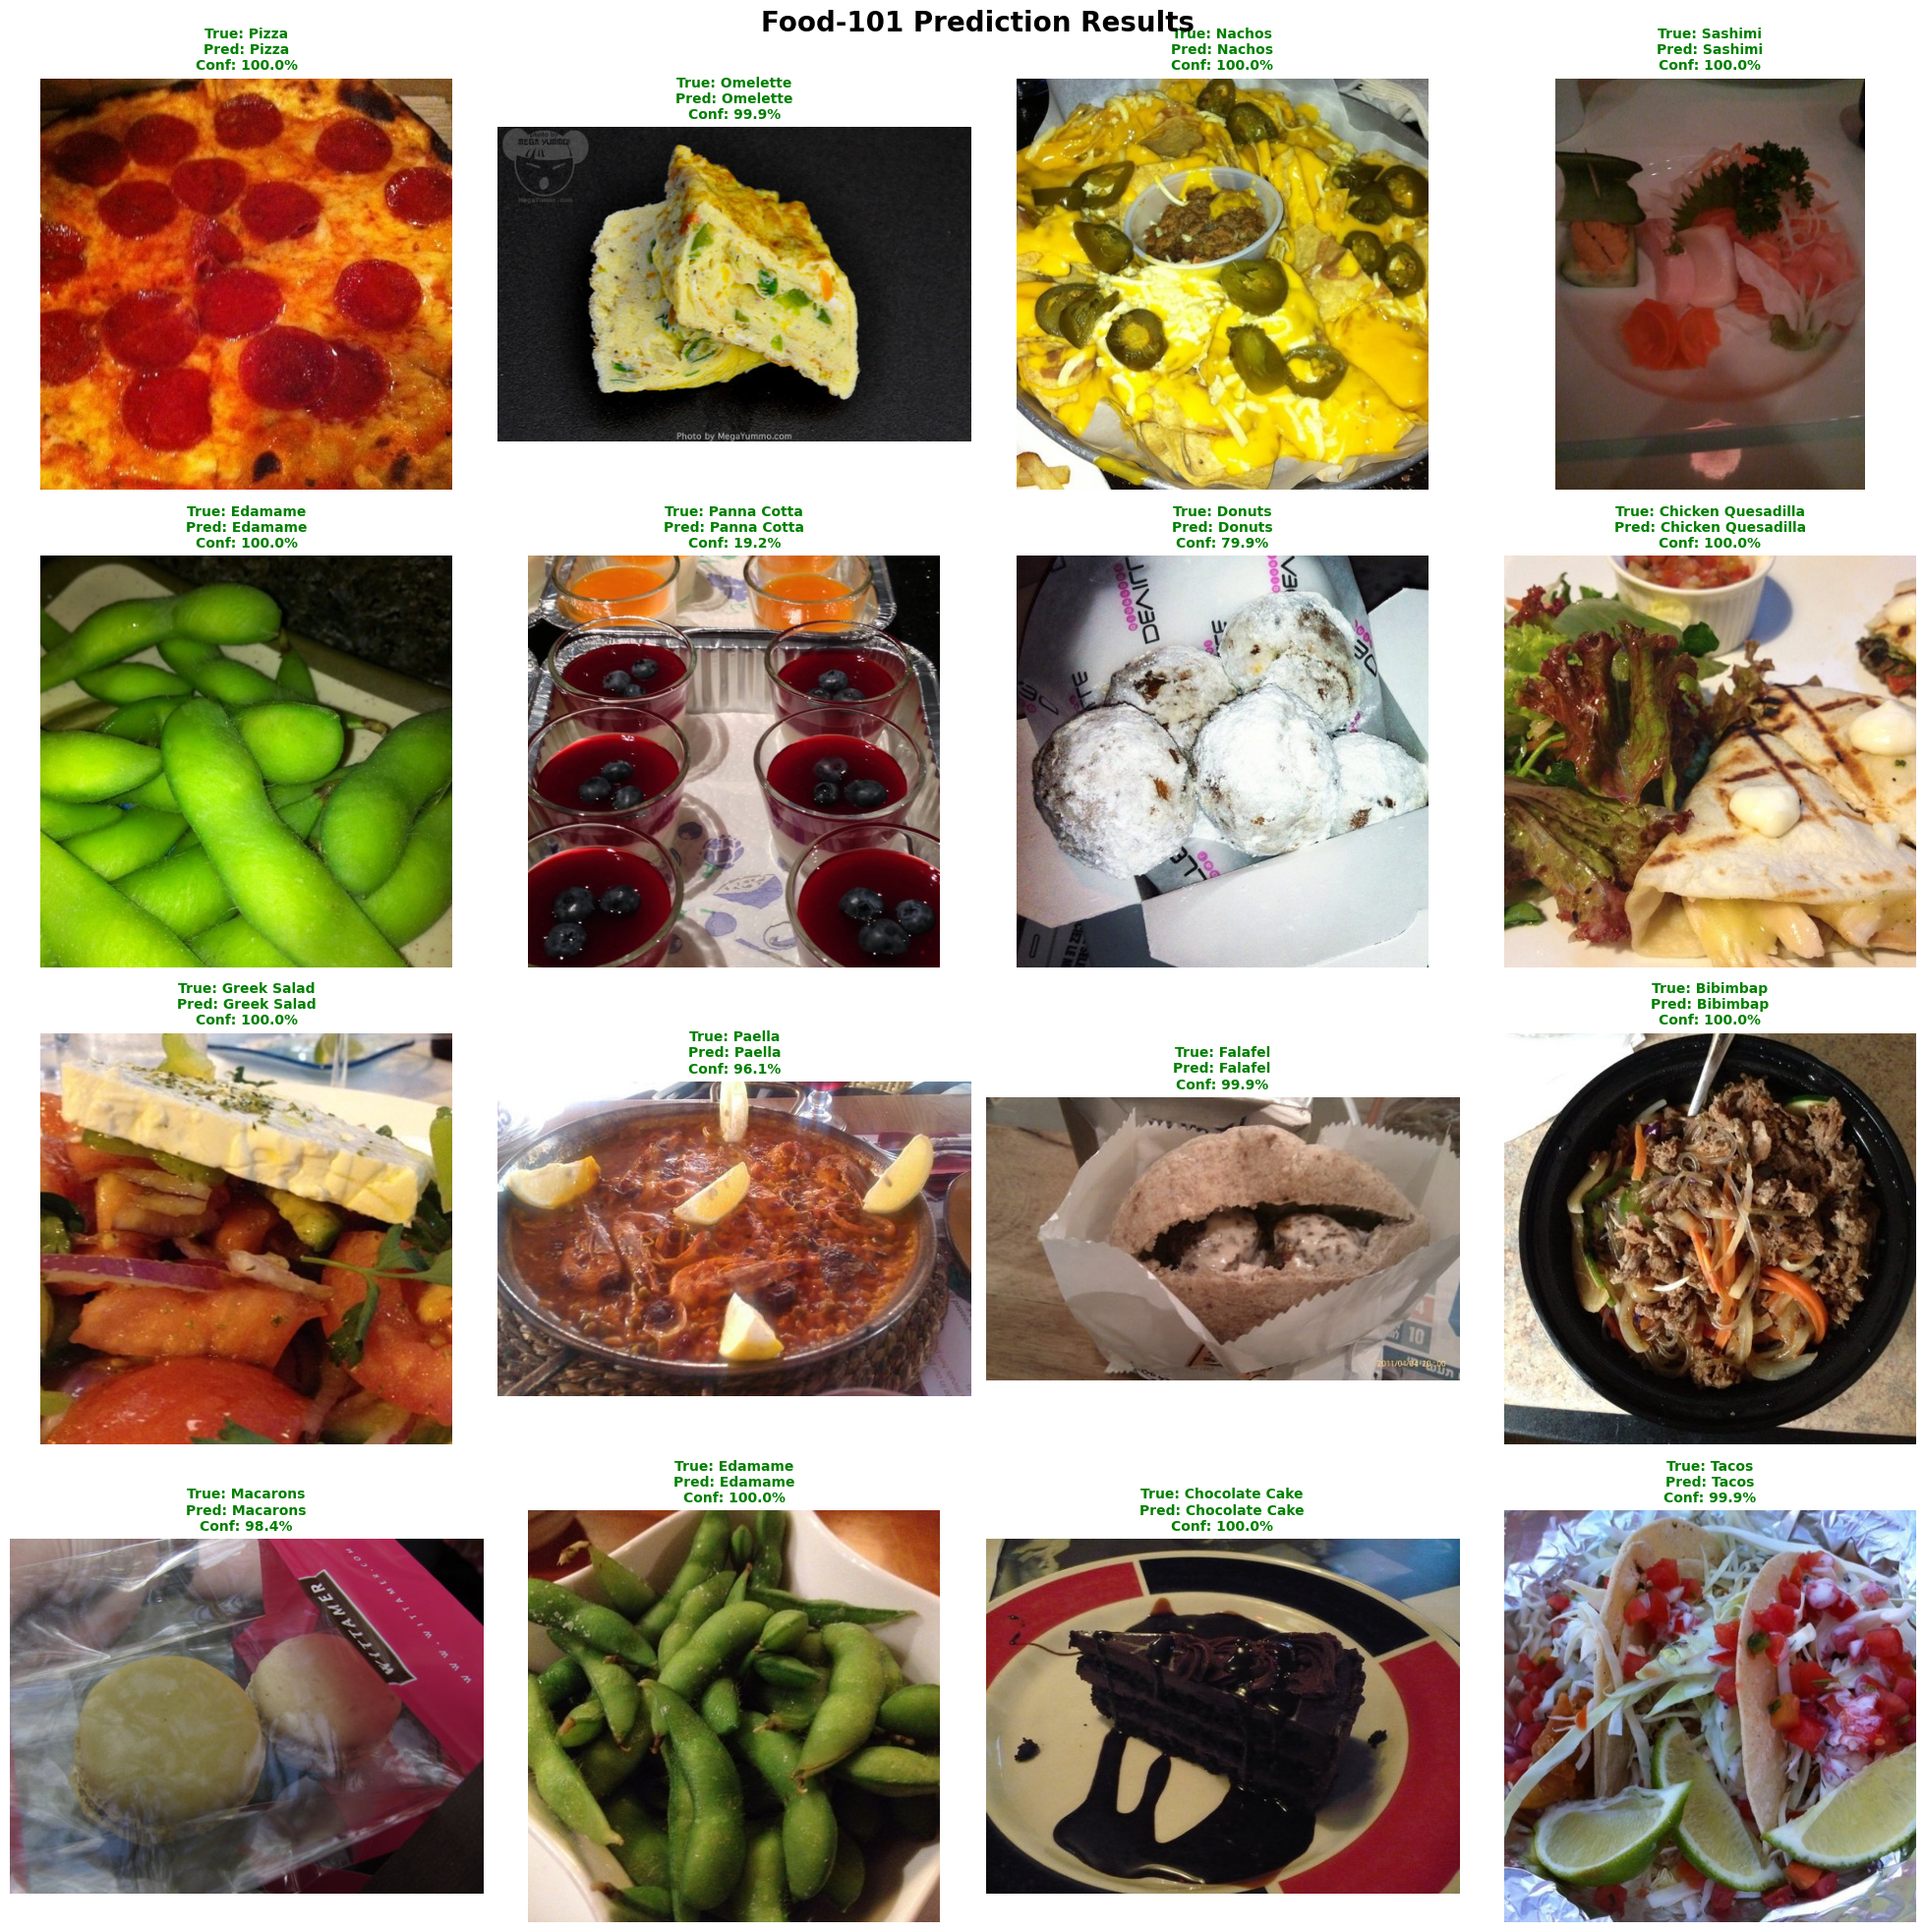


Prediction Results on 16 test samples:
Accuracy: 100.0% (16/16)
Average Confidence: 93.3%

Detailed Results:
--------------------------------------------------------------------------------
 1. ✓ CORRECT | True: Pizza                | Pred: Pizza                | Conf: 100.0%
 2. ✓ CORRECT | True: Omelette             | Pred: Omelette             | Conf: 99.9%
 3. ✓ CORRECT | True: Nachos               | Pred: Nachos               | Conf: 100.0%
 4. ✓ CORRECT | True: Sashimi              | Pred: Sashimi              | Conf: 100.0%
 5. ✓ CORRECT | True: Edamame              | Pred: Edamame              | Conf: 100.0%
 6. ✓ CORRECT | True: Panna Cotta          | Pred: Panna Cotta          | Conf: 19.2%
 7. ✓ CORRECT | True: Donuts               | Pred: Donuts               | Conf: 79.9%
 8. ✓ CORRECT | True: Chicken Quesadilla   | Pred: Chicken Quesadilla   | Conf: 100.0%
 9. ✓ CORRECT | True: Greek Salad          | Pred: Greek Salad          | Conf: 100.0%
10. ✓ CORRECT | True: Paella 

In [9]:
if __name__ == "__main__":
    main()